# Credit Score Classification

## Reading the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('train.csv', low_memory=False)

In [3]:
data.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [4]:
data.shape

(100000, 28)

In [5]:
data.dtypes

ID                           object
Customer_ID                  object
Month                        object
Name                         object
Age                          object
SSN                          object
Occupation                   object
Annual_Income                object
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                  object
Type_of_Loan                 object
Delay_from_due_date           int64
Num_of_Delayed_Payment       object
Changed_Credit_Limit         object
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt             object
Credit_Utilization_Ratio    float64
Credit_History_Age           object
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly      object
Payment_Behaviour            object
Monthly_Balance              object
Credit_Score                

## Data Pre-processing

In [6]:
# Removing rows which would not be used for analysis

columns_to_drop = ['ID', 'Customer_ID', 'Name', 'SSN','Type_of_Loan','Month']
df_cleaned = data.drop(columns=columns_to_drop)

In [7]:
# Check for duplicate rows
duplicate_rows = df_cleaned[data.duplicated()]

# Count the number of duplicate rows
num_duplicates = duplicate_rows.shape[0]
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


In [8]:
# Convert numeric columns with 'object' type to appropriate numeric types

numeric_columns = ['Age', 'Annual_Income', 'Num_of_Loan', 'Outstanding_Debt',
                   'Changed_Credit_Limit', 'Amount_invested_monthly', 'Monthly_Balance','Num_of_Delayed_Payment']
for column in numeric_columns:
    df_cleaned[column] = pd.to_numeric(df_cleaned[column], errors='coerce')
    
df_cleaned.dtypes

Age                         float64
Occupation                   object
Annual_Income               float64
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                 float64
Delay_from_due_date           int64
Num_of_Delayed_Payment      float64
Changed_Credit_Limit        float64
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt            float64
Credit_Utilization_Ratio    float64
Credit_History_Age           object
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly     float64
Payment_Behaviour            object
Monthly_Balance             float64
Credit_Score                 object
dtype: object

In [9]:
# Drop rows with missing values in critical columns
critical_columns = ['Credit_History_Age', 'Num_of_Delayed_Payment']
df_cleaned = df_cleaned.dropna(subset=critical_columns)

# Handle remaining missing values
for column in df_cleaned.columns:
    if df_cleaned[column].isnull().sum() > 0:  # Check if column has missing values
        if df_cleaned[column].dtype in ['float64', 'int64']:  # Numeric columns
            # Fill missing values with the mean
            df_cleaned.loc[:, column] = df_cleaned[column].fillna(df_cleaned[column].mean())
        else:  # Categorical columns
            # Fill missing values with the mode
            df_cleaned.loc[:, column] = df_cleaned[column].fillna(df_cleaned[column].mode()[0])

# Valid values for the 'Payment_Behaviour' column
valid_values = [
    'High_spent_Small_value_payments', 'Low_spent_Large_value_payments',
    'Low_spent_Medium_value_payments', 'High_spent_Medium_value_payments',
    'High_spent_Large_value_payments', 'Low_spent_Small_value_payments'
]

# Calculate the mode of the 'Payment_Behaviour' column
payment_behaviour_mode = df_cleaned['Payment_Behaviour'].mode()[0]

# Replace invalid values in 'Payment_Behaviour' with the mode
df_cleaned.loc[:, 'Payment_Behaviour'] = df_cleaned['Payment_Behaviour'].apply(
    lambda x: x if x in valid_values else payment_behaviour_mode
)


### Deriving new features from the existing set of features

In [10]:
df_cleaned['Debt_to_Income_Ratio'] = df_cleaned['Outstanding_Debt'] / df_cleaned['Annual_Income']
df_cleaned['Remaining_Balance'] = df_cleaned['Monthly_Balance'] - df_cleaned['Total_EMI_per_month']
df_cleaned['Savings_Ratio'] = df_cleaned['Remaining_Balance'] / df_cleaned['Annual_Income']
df_cleaned['Risky_Borrower_Flag'] = df_cleaned.apply(
    lambda row: 1 if (row['Num_of_Delayed_Payment'] > 5 or row['Credit_Mix'] == 'Poor') else 0, axis=1)

1. Debt to income ratio:
- Why Are We Doing This?

This ratio reflects a person's debt burden relative to their income.
Higher values indicate that a large portion of the individual's income is committed to debt, which may signal financial stress or risk.
It's a commonly used metric in credit scoring and lending decisions.

2. Remaining Balance
- Why are we doing this?

This feature calculates how much money remains after paying monthly EMIs (Equated Monthly Installments).
A positive balance indicates financial breathing room, while a negative value may indicate financial strain.


3. Savings Ratio
- Why are we doing this?

This feature quantifies the proportion of annual income that remains as savings after covering monthly expenses (via Remaining_Balance).
A higher ratio indicates good savings habits, while a lower or negative ratio could signal financial stress.

4.Risky Borrower flag
- Why are we doing this?

By analyzing Num_of_Delayed_Payment and Credit_Mix, the flag identifies borrowers with higher chances of financial instability or default.
High Delayed Payments: Borrowers with frequent delays in payments show a pattern of repayment difficulties.
Poor Credit Mix: Borrowers with limited or suboptimal types of credit accounts are often considered riskier.
This allows lenders or analysts to focus on individuals who are more likely to default, improving risk management.

In [11]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82122 entries, 0 to 99999
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       82122 non-null  float64
 1   Occupation                82122 non-null  object 
 2   Annual_Income             82122 non-null  float64
 3   Monthly_Inhand_Salary     82122 non-null  float64
 4   Num_Bank_Accounts         82122 non-null  int64  
 5   Num_Credit_Card           82122 non-null  int64  
 6   Interest_Rate             82122 non-null  int64  
 7   Num_of_Loan               82122 non-null  float64
 8   Delay_from_due_date       82122 non-null  int64  
 9   Num_of_Delayed_Payment    82122 non-null  float64
 10  Changed_Credit_Limit      82122 non-null  float64
 11  Num_Credit_Inquiries      82122 non-null  float64
 12  Credit_Mix                82122 non-null  object 
 13  Outstanding_Debt          82122 non-null  float64
 14  Credit

In [12]:
# Encoding

credit_score_mapping = {
    'Poor': 0,
    'Standard': 1,
    'Good': 2
}

# Apply the mapping to the target column
df_cleaned['Credit_Score'] = df_cleaned['Credit_Score'].map(credit_score_mapping)


print(df_cleaned['Credit_Score'])

0        2
2        2
3        2
5        2
8        1
        ..
99994    0
99995    0
99996    0
99997    0
99999    0
Name: Credit_Score, Length: 82122, dtype: int64


In [13]:
from sklearn.preprocessing import LabelEncoder

# Columns to encode
columns_to_encode = ['Payment_Behaviour', 'Occupation','Payment_of_Min_Amount']

# Apply Label Encoding
label_encoders = {}  # To store encoders for each column

for col in columns_to_encode:
    # Create and apply LabelEncoder
    label_encoder = LabelEncoder()
    df_cleaned[f'{col}_Label'] = label_encoder.fit_transform(df_cleaned[col].astype(str))
    label_encoders[col] = label_encoder  # Store the encoder for future reference

# Display the mapping for each column
for col in columns_to_encode:
    mapping = dict(zip(label_encoders[col].classes_, label_encoders[col].transform(label_encoders[col].classes_)))
    print(f"Mapping for {col}:", mapping)


Mapping for Payment_Behaviour: {'High_spent_Large_value_payments': 0, 'High_spent_Medium_value_payments': 1, 'High_spent_Small_value_payments': 2, 'Low_spent_Large_value_payments': 3, 'Low_spent_Medium_value_payments': 4, 'Low_spent_Small_value_payments': 5}
Mapping for Occupation: {'Accountant': 0, 'Architect': 1, 'Developer': 2, 'Doctor': 3, 'Engineer': 4, 'Entrepreneur': 5, 'Journalist': 6, 'Lawyer': 7, 'Manager': 8, 'Mechanic': 9, 'Media_Manager': 10, 'Musician': 11, 'Scientist': 12, 'Teacher': 13, 'Writer': 14, '_______': 15}
Mapping for Payment_of_Min_Amount: {'NM': 0, 'No': 1, 'Yes': 2}


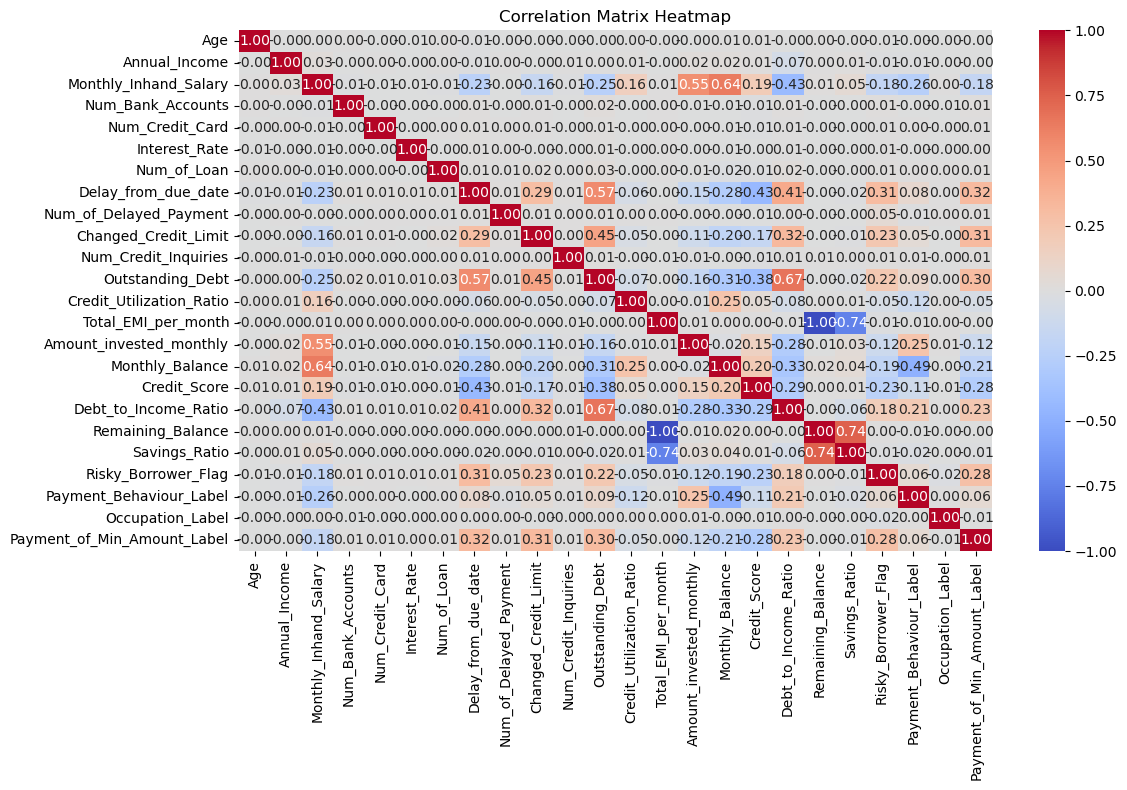

In [14]:
# Correlation matrix

correlation_matrix = df_cleaned.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

In [15]:
# Columns to drop after seeing the correlation matrix

columns_to_remove = [
    'Age',
    'Num_Credit_Card',
    'Interest_Rate',
    'Num_Bank_Accounts',
    'Outstanding_Debt',
    'Amount_invested_monthly',
    'Savings_Ratio',
    'Total_EMI_per_month',
    'Occupation',
    'Payment_Behaviour',
    'Credit_Mix',
    'Payment_of_Min_Amount',

]

# Drop the columns
data_reduced = df_cleaned.drop(columns=columns_to_remove)
print(" Shape of reduced data:" ,data_reduced.shape)

 Shape of reduced data: (82122, 17)


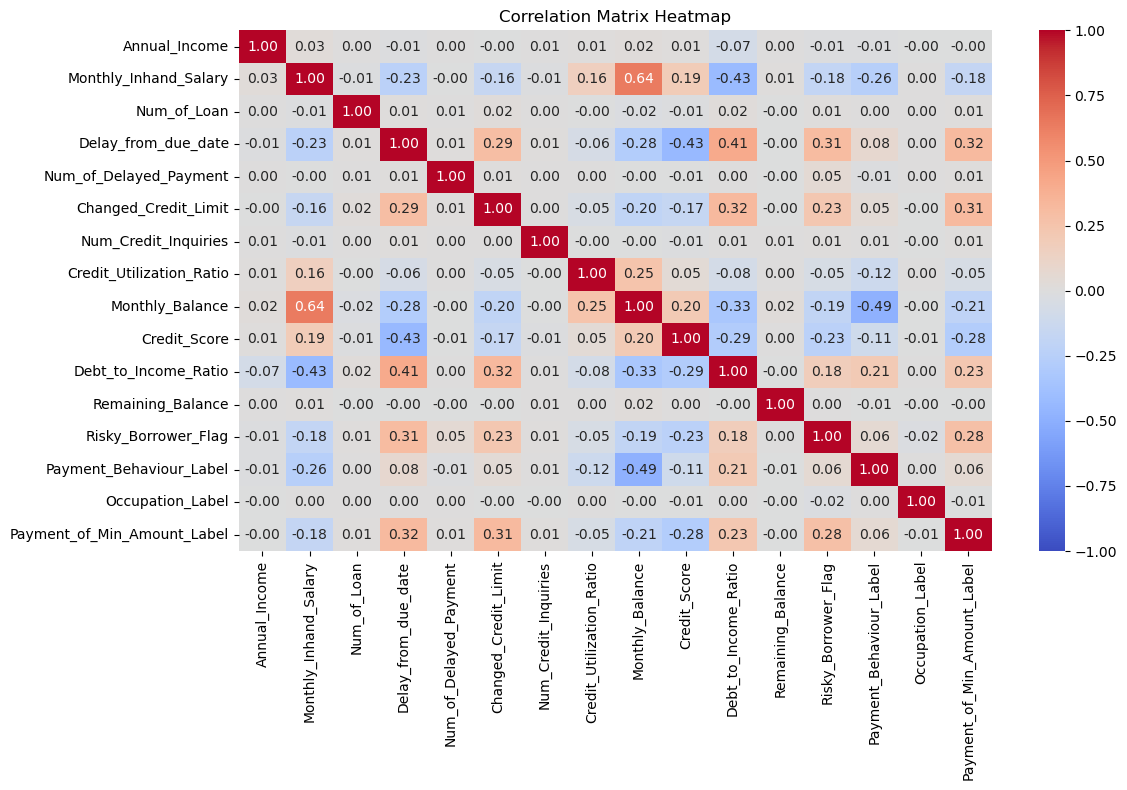

In [16]:
correlation_matrix = data_reduced.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

In [17]:
data_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82122 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Annual_Income                82122 non-null  float64
 1   Monthly_Inhand_Salary        82122 non-null  float64
 2   Num_of_Loan                  82122 non-null  float64
 3   Delay_from_due_date          82122 non-null  int64  
 4   Num_of_Delayed_Payment       82122 non-null  float64
 5   Changed_Credit_Limit         82122 non-null  float64
 6   Num_Credit_Inquiries         82122 non-null  float64
 7   Credit_Utilization_Ratio     82122 non-null  float64
 8   Credit_History_Age           82122 non-null  object 
 9   Monthly_Balance              82122 non-null  float64
 10  Credit_Score                 82122 non-null  int64  
 11  Debt_to_Income_Ratio         82122 non-null  float64
 12  Remaining_Balance            82122 non-null  float64
 13  Risky_Borrower_F

## Research question 1

## Creating a temporal column 

In [18]:
def month_on_books(entry):
    if isinstance(entry, str):
        years = int(entry.split('Years')[0].strip()) if 'Years' in entry else 0
        months = int(entry.split('and')[-1].strip().split('Months')[0].strip()) if 'Months' in entry else 0
        return years * 12 + months
    return 0

data_reduced['mob'] = data_reduced['Credit_History_Age'].apply(month_on_books)
data_reduced.drop('Credit_History_Age', axis=1, inplace=True)

data_reduced['Num_of_Delayed_Payment'] = data_reduced.apply(
    lambda row: row['mob'] if row['Num_of_Delayed_Payment'] > row['mob'] else row['Num_of_Delayed_Payment'],
    axis=1
)

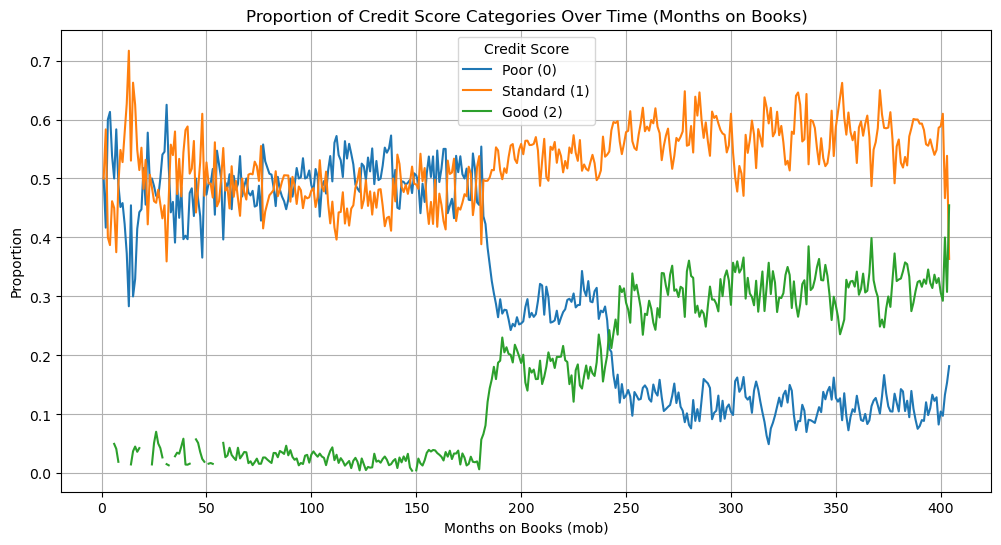

In [19]:
# Group by 'mob' and calculate the proportion of each credit score category
temporal_trends = data_reduced.groupby('mob')['Credit_Score'].value_counts(normalize=True).unstack()

# Plot the trends
temporal_trends.plot(kind='line', figsize=(12, 6))
plt.title("Proportion of Credit Score Categories Over Time (Months on Books)")
plt.xlabel("Months on Books (mob)")
plt.ylabel("Proportion")
plt.legend(title="Credit Score", labels=["Poor (0)", "Standard (1)", "Good (2)"])
plt.grid()
plt.show()

This graph shows how the proportion of people with different credit scores (Poor, Standard, Good) changes as the age of their account (in months) increases.

- Poor Credit Scores (0):

Early on (first 50 months), a large proportion of people have poor credit scores, and the numbers fluctuate a lot.
Over time, the proportion of people with poor credit scores decreases steadily. This suggests that as accounts get older, fewer people remain in the "poor" category.
- Standard Credit Scores (1):

Most people fall into the "standard" credit score category for a large portion of the timeline, especially after the first 50 months.
This category stays relatively steady over time, dominating the middle of the graph.


- Good Credit Scores (2):

At the start, very few people have a "good" credit score.
As accounts age, more and more people move into the "good" credit score category, especially after 200 months. This shows that people tend to improve their credit scores with time.

In [20]:
!pip install xgboost

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


## Running the ML algorithm

In [22]:
def run_ml_model(algorithm, X, y):
    """
    Runs the specified machine learning model and returns the classification report.

    Parameters:
    - algorithm: str ("random_forest", "logistic_regression", "xgboost")
    - X: Features (DataFrame)
    - y: Target (Series)

    Returns:
    - Classification report (string)
    """
    # Split data into train and test sets
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Initialize the model based on the algorithm
    if algorithm == "random_forest":
        model = RandomForestClassifier(random_state=42)
    elif algorithm == "logistic_regression":
        model = LogisticRegression(random_state=42, max_iter=1000)
    elif algorithm == "xgboost":
        model = XGBClassifier(random_state=42)
    else:
        raise ValueError("Invalid algorithm specified. Choose from 'random_forest', 'logistic_regression', 'xgboost'.")

    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Generate and return the classification report
    return classification_report(y_test, y_pred)

### Using MOB

In [23]:
# Split data into train and test sets
X = data_reduced.drop(columns=['Credit_Score'])
y = data_reduced['Credit_Score']


In [24]:
rf_report = run_ml_model("random_forest", X, y)
print("Random Forest Classification Report:\n", rf_report)

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.73      0.74      4800
           1       0.75      0.80      0.77      8667
           2       0.68      0.58      0.62      2958

    accuracy                           0.74     16425
   macro avg       0.73      0.70      0.71     16425
weighted avg       0.74      0.74      0.74     16425



In [25]:
lr_report = run_ml_model("logistic_regression", X, y)
print("\nLogistic Regression Classification Report:\n", lr_report)


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.41      0.50      4800
           1       0.60      0.81      0.69      8667
           2       0.52      0.31      0.38      2958

    accuracy                           0.60     16425
   macro avg       0.59      0.51      0.52     16425
weighted avg       0.60      0.60      0.58     16425



In [26]:
xgb_report = run_ml_model("xgboost", X, y)
print("\nXGBoost Classification Report:\n", xgb_report)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.67      0.70      4800
           1       0.71      0.77      0.74      8667
           2       0.59      0.52      0.56      2958

    accuracy                           0.70     16425
   macro avg       0.68      0.65      0.66     16425
weighted avg       0.69      0.70      0.69     16425



Random forest - best model so we will be using this model for further analysis

### If we do not use MOB:

In [27]:
# Not using MOB

X_n = data_reduced.drop(columns=['Credit_Score','mob'])
y_n = data_reduced['Credit_Score']
rf_report_n = run_ml_model("random_forest", X_n, y_n)
print("\nRandom Forest Classification Report (Without MOB):\n", rf_report_n)


Random Forest Classification Report (Without MOB):
               precision    recall  f1-score   support

           0       0.75      0.70      0.72      4800
           1       0.73      0.79      0.76      8667
           2       0.65      0.54      0.59      2958

    accuracy                           0.72     16425
   macro avg       0.71      0.68      0.69     16425
weighted avg       0.72      0.72      0.72     16425



## Research question 2

## Creating new columns to visualise financial impact

In [28]:
# Flag customers with loan defaults (e.g., more than 3 delayed payments)
data_reduced['Loan_Default_Flag'] = (data_reduced['Num_of_Delayed_Payment'] > 3).astype(int)
# Flag customers with high debt-to-income ratio
data_reduced['High_DTI_Flag'] = (data_reduced['Debt_to_Income_Ratio'] > 0.4).astype(int)
# Flag customers with frequent credit inquiries (e.g., more than 5)
data_reduced['Frequent_Credit_Inquiries_Flag'] = (data_reduced['Num_Credit_Inquiries'] > 5).astype(int)
# Flag poor payment behavior based on existing labels
# 2 = High_spent_Small_value_payments & 5 = Low_spent_Small_value_payments
data_reduced['Poor_Payment_Behaviour_Flag'] = ((data_reduced['Payment_Behaviour_Label'] == 2) | (data_reduced['Payment_Behaviour_Label'] == 5)).astype(int)


In [29]:
data_reduced

,Annual_Income,Monthly_Inhand_Salary,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Utilization_Ratio,Monthly_Balance,Credit_Score,...,Remaining_Balance,Risky_Borrower_Flag,Payment_Behaviour_Label,Occupation_Label,Payment_of_Min_Amount_Label,mob,Loan_Default_Flag,High_DTI_Flag,Frequent_Credit_Inquiries_Flag,Poor_Payment_Behaviour_Flag
0,19114.120000,1824.843333,4.0,3,7.0,11.270000,4.0,26.822620,312.494089,2,...,262.919139,1,2,12,1,265,1,0,0,1
2,19114.120000,4195.076446,4.0,3,7.0,10.402608,4.0,28.609352,331.209863,2,...,281.634914,1,4,12,1,267,1,0,0,0
3,19114.120000,4195.076446,4.0,5,4.0,6.270000,4.0,31.377862,223.451310,2,...,173.876361,0,5,12,1,268,1,0,0,1
5,19114.120000,4195.076446,4.0,8,4.0,9.270000,4.0,27.262259,340.479212,2,...,290.904263,0,5,12,1,270,1,0,0,1
8,34847.840000,3037.986667,1.0,3,4.0,5.420000,2.0,24.464031,470.690627,1,...,451.874412,0,5,15,1,319,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,39628.990000,3359.415833,2.0,20,6.0,9.500000,3.0,39.323569,410.256158,0,...,375.152135,1,1,9,1,377,1,0,0,0
99995,39628.990000,3359.415833,2.0,23,7.0,11.500000,3.0,34.663572,479.866228,0,...,444.762206,1,0,9,1,378,1,0,0,0
99996,39628.990000,3359.415833,2.0,18,7.0,11.500000,3.0,40.565631,496.651610,0,...,461.547588,1,1,9,1,379,1,0,0,0
99997,39628.990000,3359.415833,2.0,27,6.0,11.500000,3.0,41.255522,516.809083,0,...,481.705061,1,0,9,1,380,1,0,0,0


In [30]:
data_reduced['Financial_Stress_Score'] = (
    data_reduced['Loan_Default_Flag'] +
    data_reduced['High_DTI_Flag'] +
    data_reduced['Frequent_Credit_Inquiries_Flag'] +
    data_reduced['Poor_Payment_Behaviour_Flag']
)

In [31]:
# Group by Financial Stress Score
stress_impact = data_reduced.groupby('Financial_Stress_Score')['Credit_Score'].value_counts(normalize=True).unstack()

# Display the proportion of credit scores for each stress level
print(stress_impact)

Credit_Score                   0         1         2
Financial_Stress_Score                              
0                       0.152235  0.363687  0.484078
1                       0.119282  0.583366  0.297352
2                       0.302374  0.552918  0.144708
3                       0.487544  0.464364  0.048092
4                       0.525581  0.455814  0.018605


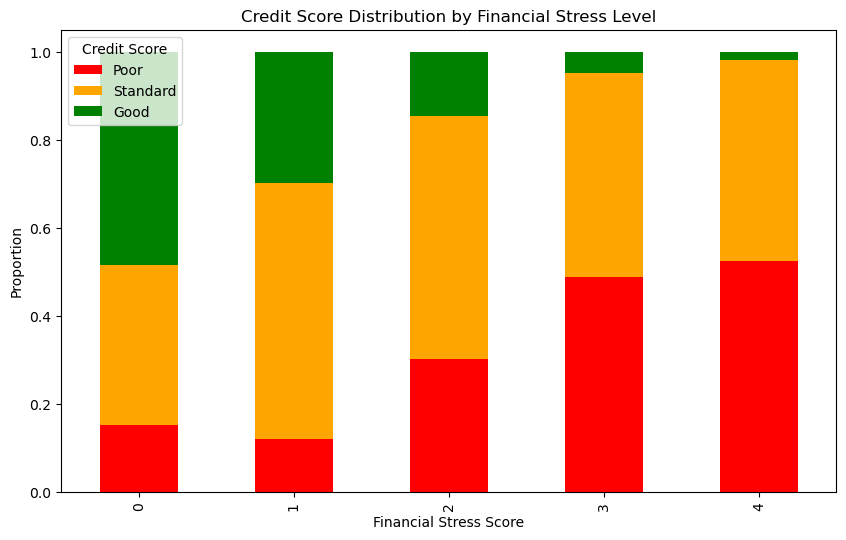

In [32]:
import matplotlib.pyplot as plt
custom_colors = ["red", "orange", "green"]

stress_impact.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=custom_colors
)

plt.title("Credit Score Distribution by Financial Stress Level")
plt.xlabel("Financial Stress Score")
plt.ylabel("Proportion")
plt.legend(title="Credit Score", labels=["Poor", "Standard", "Good"])
plt.show()

This graph shows how credit scores (Good, Standard, Poor) change as financial stress increases. At low financial stress levels (score = 0), most people have either Good or Standard credit scores, with very few in the Poor category. As financial stress increases to moderate levels (scores = 1 or 2), the proportion of Poor scores starts to rise, while Good scores decrease. At high stress levels (scores = 3 or 4), most people have a Poor credit score, and very few maintain a Good score. This pattern shows that as financial stress increases, creditworthiness declines significantly, making it crucial to monitor and support borrowers with high stress levels to prevent further credit score deterioration.

## Taking temporal variables as well as financial variables into account

In [33]:
# Prepare the dataset
# Assume `data_reduced` contains the relevant features and target
X = data_reduced.drop(columns=['Credit_Score'])  # Features
y = data_reduced['Credit_Score']  # Target

In [34]:
rf_report = run_ml_model("random_forest", X, y)
print("Random Forest Classification Report:\n", rf_report)

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.71      0.73      4800
           1       0.74      0.80      0.77      8667
           2       0.66      0.56      0.61      2958

    accuracy                           0.73     16425
   macro avg       0.72      0.69      0.70     16425
weighted avg       0.73      0.73      0.73     16425



## Model Tuning

Hyperparameter tuning was performed, and the best parameters were selected. Multiple parameter tests were not shown as they were done initially, and running them takes significant time, focusing instead on the final optimal parameters.

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


# param_grid = {
#     'n_estimators': [100, 200, 300],  
#     'max_depth': [10, 20, 30],  
#     'min_samples_split': [2, 5, 10], 
#     'min_samples_leaf': [1, 2, 4]
# }

# Define the best parameter grid
param_grid = {
    'n_estimators': [300],  
    'max_depth': [30],  
    'min_samples_split': [2], 
    'min_samples_leaf': [1]
}

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,  test_size=0.2, random_state=42)

# Initialize the model
rf = RandomForestClassifier(random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv = 3, scoring='f1_weighted', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate the optimized model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
              precision    recall  f1-score   support

           0       0.76      0.71      0.73      4800
           1       0.74      0.80      0.77      8667
           2       0.66      0.58      0.62      2958

    accuracy                           0.73     16425
   macro avg       0.72      0.69      0.71     16425
weighted avg       0.73      0.73      0.73     16425



## Selecting the top 5 features

In [36]:
feature_imp = pd.DataFrame({'Name':X.columns, 'Importance':best_rf.feature_importances_})

feature_imp = feature_imp.sort_values('Importance',ascending=False).reset_index(drop=True)
feature_imp

,Name,Importance
0,Debt_to_Income_Ratio,0.093757
1,Delay_from_due_date,0.091741
2,mob,0.090135
3,Changed_Credit_Limit,0.085161
4,Annual_Income,0.068022
5,Remaining_Balance,0.066798
6,Monthly_Balance,0.062989
7,Monthly_Inhand_Salary,0.062777
8,Num_Credit_Inquiries,0.062743
9,Credit_Utilization_Ratio,0.062437


In [37]:
top5= feature_imp.Name[:5].tolist()
top5

['Debt_to_Income_Ratio',
 'Delay_from_due_date',
 'mob',
 'Changed_Credit_Limit',
 'Annual_Income']

In [38]:
X = data_reduced[top5]
y = data_reduced['Credit_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77      4800
           1       0.76      0.80      0.78      8667
           2       0.72      0.63      0.67      2958

    accuracy                           0.76     16425
   macro avg       0.75      0.73      0.74     16425
weighted avg       0.76      0.76      0.76     16425



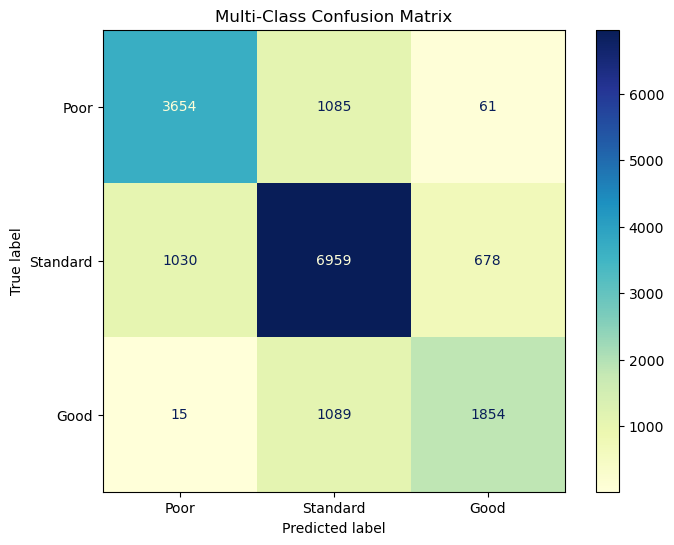

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

# Labels for the classes
class_names = ['Poor', 'Standard', 'Good']

# Plot the confusion matrix using Matplotlib
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(cmap="YlGnBu", ax=plt.gca())
plt.title("Multi-Class Confusion Matrix")
plt.show()

## Normalizing the confusion matrix to get the percentages

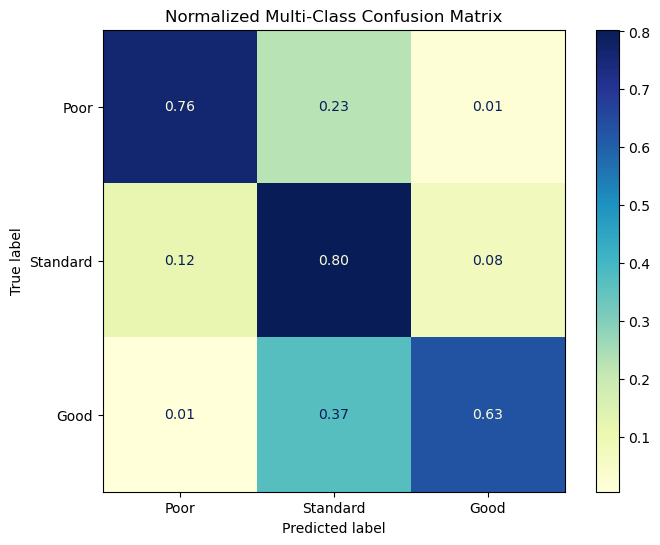

In [42]:
# Normalize the confusion matrix by row (true labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names).plot(cmap="YlGnBu", ax=plt.gca(), values_format=".2f")
plt.title("Normalized Multi-Class Confusion Matrix")
plt.show()